# Post-Bining: Experimental Place Cells

This notebook reads an experimental dataset after:
- cell firings,
- labels,
- times,
have been binned according to a given time-step `timestep_microsec`.

Specifically, we read the files obtained after the processing function `experimental.datasets.load_place_cells` that:
- bins cell firings, times and labels according to the time-step,
- save the results in 3 files.

Plotting the binned files allows us to determine how many neurons were recorded in each experiment.

## Set up

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


## Imports

In [2]:
import json
import glob

import matplotlib.pyplot as plt
import neuralgeom.datasets.experimental as experimental
import neuralgeom.datasets.utils as utils
import numpy as np
import pandas as pd

RAW_DIR = os.path.join(os.getcwd(), "data", "raw")
print(f"The raw data is located in the directory:\n{RAW_DIR}.")
BINNED_DIR = os.path.join(os.getcwd(), "data", "binned")
print(f"The binned data is located in the directory:\n{BINNED_DIR}.")

INFO: Using pytorch backend


The raw data is located in the directory:
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/home/nmiolane/code/neuralgeom/neuralgeom/data/binned.


## Preprocess all experiments 

### Get number of times after binning with a given timestep

In [5]:
string_base = os.path.join(RAW_DIR, "expt*.mat")
print(string_base)
paths = sorted(glob.glob(string_base))

print(f"Raw data in directory {RAW_DIR}:")
for path in paths:
    print(path)

/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt*.mat
Raw data in directory /home/nmiolane/code/neuralgeom/neuralgeom/data/raw:
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt10.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt10_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt11.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt11_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt12.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt12_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt13.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt13_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt14.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt14_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt15.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt15_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt16.mat
/home/nmiolane/code/neuralgeom/neuralgeom

In [6]:
from joblib import Parallel, delayed

timestep_ns = int(1e5)

expt_ids = []
for path in paths:
    basename = os.path.basename(path).split(".")[0]
    expt_id = basename[4:]
    expt_ids.append(expt_id)

def bin_place_cells(expt_id):
    print(f"Processing expt {expt_id} at timestep {timestep_ns}...")

    try:
        place_cells, labels = experimental.load_place_cells(
    expt_id=expt_id, timestep_microsec=timestep_ns
)
        return {expt_id: place_cells.shape[0]}
    except Exception:
        print(f"!! Error for {basename}")
        return {expt_id: -1}
    
results = Parallel(n_jobs=-1)(delayed(bin_place_cells)(expt_id) for expt_id in expt_ids)

INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt13_times_timestep100000.txt. Preprocessing needed:
INFO: Loading experiment 13 to bin firing times into times...
INFO: Using pytorch backend
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt12_hd_times_timestep100000.tx

Processing expt 31_hd at timestep 100000...
Processing expt 4 at timestep 100000...


INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 25...
INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 29...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains', 'radius2', 'x', 'y', 'z',
       'rx_head', 'ry_head', 'rz_head', 'angles_tracked', 'angles_head',
       'success'],
      dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt15_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 30...
INFO: Counting firings per time-step in cell 21...
INFO: Counting firings per time-step in cell 1...
INFO: Counting firings per time-step in cell 11...
INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 8...
INFO: Counting firings per time-step in cell 19...
INFO: Nb of firing times  (all cells) after deleting duplicates: 1462

Processing expt 10 at timestep 100000...
Processing expt 34_old at timestep 100000...
!! Error for expt9_hd
Processing expt 35_hd at timestep 100000...


INFO: Counting firings per time-step in cell 12...
INFO: Counting firings per time-step in cell 11...
INFO: Counting firings per time-step in cell 29...
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 26...
INFO: Using pytorch backend
INFO: Counting firings per time-step in cell 10...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt51_hd_times_timestep100000.txt. Preprocessing needed:
INFO: Loading experiment 51_hd to bin firing times into times...
INFO: Nb of firing times (all cells) before deleting duplicates: 162185.
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 15...
INFO: Counting firings per time-step in cell 31...
INFO: Counting firings per time-step in cell 24...
INFO: # - Saving place_cells of shape (38828, 12) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neur

Processing expt 17 at timestep 100000...
Processing expt 41 at timestep 100000...


INFO: Counting firings per time-step in cell 19...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt45_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 23...
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 13...
INFO: Counting firings per time-step in cell 11...
INFO: Counting firings per time-step in cell 3...
INFO: Counting firings per time-step in cell 8...
INFO: Counting firings per time-step in cell 18...
INFO: Counting firings per time-step in cell 32...
INFO: Counting firings per time-step in cell 38...
INFO: Counting firings per time-step in cell 24...
INFO: Counting firings per time-step in cell 20...
INFO: Counting firings per time-step in cell 14...
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 5...
INFO: Nb of firing times  (all cells) afte

Processing expt 32_hd at timestep 100000...
Processing expt 45 at timestep 100000...


INFO: Counting firings per time-step in cell 14...
INFO: Using pytorch backend
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt7_times_timestep100000.txt. Preprocessing needed:
INFO: Loading experiment 7 to bin firing times into times...
INFO: Nb of firing times (all cells) before deleting duplicates: 16799.
INFO: # - Saving place_cells of shape (39026, 11) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt48_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt48_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt48_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 3...
INFO: Counting firings per time-step in cell 25...
INFO: Nb of firing times  (all cells) after deleting duplicates: 16793.
INFO: # - Saving 

Processing expt 15 at timestep 100000...
Processing expt 3_hd at timestep 100000...


INFO: Counting firings per time-step in cell 15...
INFO: Counting firings per time-step in cell 26...
INFO: Counting firings per time-step in cell 9...
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 17...
INFO: Counting firings per time-step in cell 3...
INFO: Counting firings per time-step in cell 19...
INFO: Counting firings per time-step in cell 19...
INFO: Counting firings per time-step in cell 15...
INFO: Counting firings per time-step in cell 30...
INFO: Counting firings per time-step in cell 29...
INFO: Counting firings per time-step in cell 36...
INFO: Counting firings per time-step in cell 1...
INFO: Counting firings per time-step in cell 1...
INFO: Counting firings per time-step in cell 16...
INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 10...
INFO: Counting firings per time-step in cell 16...
INFO: Counting firings per time-step 

Processing expt 12_hd at timestep 100000...
Processing expt 48 at timestep 100000...


INFO: Counting firings per time-step in cell 6...
INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 6...
INFO: Counting firings per time-step in cell 21...
INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 36...
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 34...
INFO: Counting firings per time-step in cell 33...
INFO: Counting firings per time-step in cell 4...
INFO: Counting firings per time-step in cell 35...
INFO: Counting firings per time-step in cell 7...
INFO: Counting firings per time-step in cell 18...
INFO: Counting firings per time-step in cell 21...
INFO: Counting firings per time-step in cell 6...
INFO: Counting firings per time-step in cell 8...
INFO: Counting firings per time-step in cell 24...
INFO: Counting firings per time-step in cell 21...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dt

Processing expt 2 at timestep 100000...
Processing expt 37_hd at timestep 100000...


INFO: Counting firings per time-step in cell 13...
INFO: Counting firings per time-step in cell 29...
INFO: Counting firings per time-step in cell 30...
INFO: Counting firings per time-step in cell 37...
INFO: Counting firings per time-step in cell 8...
INFO: Counting firings per time-step in cell 18...
INFO: Counting firings per time-step in cell 5...
INFO: # - Saving place_cells of shape (21554, 38) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt14_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt14_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt14_hd_place_cells_timestep100000.npy! Loading...
INFO: Averaging tracking variables per time-step...
INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 8...
INFO: Counting firings per time-step in cell 10...
INFO: Counting firings per ti

Processing expt 12 at timestep 100000...
Processing expt 39 at timestep 100000...


INFO: Counting firings per time-step in cell 44...
INFO: Counting firings per time-step in cell 15...
INFO: Counting firings per time-step in cell 19...
INFO: Counting firings per time-step in cell 12...
INFO: Counting firings per time-step in cell 12...
INFO: Counting firings per time-step in cell 14...
INFO: Counting firings per time-step in cell 11...
INFO: Counting firings per time-step in cell 29...
INFO: Counting firings per time-step in cell 13...
INFO: Counting firings per time-step in cell 13...
INFO: # - Saving place_cells of shape (20900, 44) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt42_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt42_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt42_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counti

Processing expt 13 at timestep 100000...
Processing expt 43 at timestep 100000...


INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 42...
INFO: Counting firings per time-step in cell 44...
INFO: Counting firings per time-step in cell 2...
INFO: Counting firings per time-step in cell 37...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 20...
INFO: Counting firings per time-step in cell 45...
INFO: Counting firings per time-step in cell 23...
INFO: Counting firings per time-step in cell 48...
INFO: Counting firings per time-step in cell 18...
INFO: Counting firings per time-step in cell 43...
INFO: Counting firings per time-step in cell 28...
INFO: Counting firings per time-step in cell 38...
INFO: Counting firings per time-step in cell 41...
INFO: Counting firings per time-step in cell 41...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neural

Processing expt 21_hd at timestep 100000...


INFO: Counting firings per time-step in cell 24...
INFO: Counting firings per time-step in cell 8...
INFO: Counting firings per time-step in cell 23...
INFO: Counting firings per time-step in cell 18...
INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 22...
INFO: Counting firings per time-step in cell 26...
INFO: Counting firings per time-step in cell 53...
INFO: Counting firings per time-step in cell 30...
INFO: Counting firings per time-step in cell 43...
INFO: Counting firings per time-step in cell 25...
INFO: Counting firings per time-step in cell 23...
INFO: Counting firings per time-step in cell 54...
INFO: Counting firings per time-step in cell 28...
INFO: Counting firings per time-step in cell 24...
INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 19...
INFO: Counting firings per time-step in cell 23...
INFO: Counting firings per time-step in cell 44...
INFO: # - Saving DataFrame with 

Processing expt 11 at timestep 100000...
Processing expt 41_hd at timestep 100000...


INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 51...
INFO: Counting firings per time-step in cell 49...
INFO: # - Saving place_cells of shape (17942, 28) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt9_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt9_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt9_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 32...
INFO: Counting firings per time-step in cell 31...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt38_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 37...
INFO: Counting fir

Processing expt 11_hd at timestep 100000...
Processing expt 42_hd at timestep 100000...


INFO: Counting firings per time-step in cell 61...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt47_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 35...
INFO: Counting firings per time-step in cell 44...
INFO: Counting firings per time-step in cell 37...
INFO: Counting firings per time-step in cell 30...
INFO: Counting firings per time-step in cell 62...
INFO: Counting firings per time-step in cell 36...
INFO: Counting firings per time-step in cell 45...
INFO: Counting firings per time-step in cell 63...
INFO: Counting firings per time-step in cell 38...
INFO: Counting firings per time-step in cell 34...
INFO: Counting firings per time-step in cell 37...
INFO: Counting firings per time-step in cell 31...
INFO: Counting firings per time-step in cell 64...
INFO: Counting firings per time-step in cell 46...
INFO: Counting firings per time-st

Processing expt 18_hd at timestep 100000...


INFO: Counting firings per time-step in cell 32...
INFO: Counting firings per time-step in cell 47...
INFO: Counting firings per time-step in cell 66...
INFO: Counting firings per time-step in cell 39...
INFO: Counting firings per time-step in cell 36...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 35...
INFO: # - Saving place_cells of shape (15920, 67) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt45_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt45_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt45_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 48...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 33...
INFO: Counti

Processing expt 17_hd at timestep 100000...
Processing expt 8 at timestep 100000...


INFO: Counting firings per time-step in cell 34...
INFO: Counting firings per time-step in cell 38...
INFO: Counting firings per time-step in cell 37...
INFO: Counting firings per time-step in cell 42...
INFO: Counting firings per time-step in cell 42...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt45_hd_labels_timestep100000.txt...


Processing expt 10_hd at timestep 100000...
Processing expt 63_hd at timestep 100000...


INFO: Counting firings per time-step in cell 39...
INFO: Counting firings per time-step in cell 38...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 39...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 41...
INFO: Counting firings per time-step in cell 35...
INFO: Counting firings per time-step in cell 49...
INFO: Counting firings per time-step in cell 41...
INFO: Counting firings per time-step in cell 43...
INFO: Counting firings per time-step in cell 36...
INFO: Counting firings per time-step in cell 9...
INFO: Counting firings per time-step in cell 50...
INFO: Counting firings per time-step in cell 42...
INFO: Counting firings per time-step in cell 43...
INFO: Counting firings per time-step in cell 44...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 51...
INFO: # - Saving place_cells of shape (20727, 43) to /home/nmiolan

Processing expt 26_hd at timestep 100000...
Processing expt 46_hd at timestep 100000...


INFO: Counting firings per time-step in cell 43...
INFO: Counting firings per time-step in cell 46...
INFO: Counting firings per time-step in cell 38...
INFO: Counting firings per time-step in cell 11...
INFO: Counting firings per time-step in cell 45...
INFO: Counting firings per time-step in cell 53...
INFO: Counting firings per time-step in cell 44...
INFO: Counting firings per time-step in cell 47...


Processing expt 7 at timestep 100000...


INFO: Counting firings per time-step in cell 39...
INFO: Counting firings per time-step in cell 12...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt50_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 54...
/home/nmiolane/anaconda3/envs/neuralgeom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nmiolane/anaconda3/envs/neuralgeom/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains', 'radius2', 'x', 'y', 'z',
       'rx_head', 'ry_head', 'rz_head', 'angles_tracked', 'angles_head',
       'success'],
      dtype='object') to /home/nmiolane/code/neuralgeom/n

Processing expt 14_hd at timestep 100000...


INFO: # - Saving place_cells of shape (21785, 55) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt43_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt43_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt43_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 49...
INFO: Counting firings per time-step in cell 40...
INFO: Counting firings per time-step in cell 13...
INFO: Counting firings per time-step in cell 46...
INFO: Counting firings per time-step in cell 47...
INFO: Counting firings per time-step in cell 50...
INFO: Counting firings per time-step in cell 47...
INFO: Counting firings per time-step in cell 41...
INFO: Counting firings per time-step in cell 48...
INFO: Counting firings per time-step in cell 14...
INFO: Counti

Processing expt 30_hd at timestep 100000...
Processing expt 40_hd at timestep 100000...


INFO: Counting firings per time-step in cell 50...
INFO: Counting firings per time-step in cell 51...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt48_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 17...
INFO: # - Saving place_cells of shape (23615, 51) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt52_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt52_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt52_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 52...
INFO: Counting firings per time-step in cell 18...
INFO: Counting firings per time-step in cell 53...
INFO: Counting 

Processing expt 33_hd at timestep 100000...
Processing expt 36_hd at timestep 100000...


INFO: Counting firings per time-step in cell 57...
INFO: Counting firings per time-step in cell 19...
INFO: # - Saving place_cells of shape (25806, 58) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt44_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt44_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt44_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: Counting firings per time-step in cell 20...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt51_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 21...


Processing expt 14 at timestep 100000...
Processing expt 39_hd at timestep 100000...


INFO: Counting firings per time-step in cell 22...
INFO: Counting firings per time-step in cell 23...
INFO: Counting firings per time-step in cell 24...
INFO: Counting firings per time-step in cell 25...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt44_hd_labels_timestep100000.txt...
INFO: Counting firings per time-step in cell 26...


Processing expt 13_hd at timestep 100000...
Processing expt 49_hd at timestep 100000...


INFO: Counting firings per time-step in cell 27...
INFO: Counting firings per time-step in cell 28...
INFO: Counting firings per time-step in cell 29...
INFO: Counting firings per time-step in cell 30...


Processing expt 34_hd at timestep 100000...
Processing expt 38_hd at timestep 100000...


INFO: Counting firings per time-step in cell 31...


Processing expt 20_hd at timestep 100000...
Processing expt 9_hd at timestep 100000...


INFO: Counting firings per time-step in cell 32...
INFO: Counting firings per time-step in cell 33...
INFO: Counting firings per time-step in cell 34...
INFO: Counting firings per time-step in cell 35...
INFO: Counting firings per time-step in cell 36...
INFO: Counting firings per time-step in cell 37...
INFO: Counting firings per time-step in cell 38...


Processing expt 34 at timestep 100000...
Processing expt 9 at timestep 100000...


INFO: Counting firings per time-step in cell 39...
INFO: Counting firings per time-step in cell 40...


Processing expt 52_hd at timestep 100000...


INFO: Counting firings per time-step in cell 41...
INFO: Counting firings per time-step in cell 42...


Processing expt 51_hd at timestep 100000...


INFO: Counting firings per time-step in cell 43...
INFO: Counting firings per time-step in cell 44...
INFO: Counting firings per time-step in cell 45...


Processing expt 16 at timestep 100000...
Processing expt 47_hd at timestep 100000...


INFO: Counting firings per time-step in cell 46...
INFO: Counting firings per time-step in cell 47...
INFO: Counting firings per time-step in cell 48...
INFO: Counting firings per time-step in cell 49...
INFO: Counting firings per time-step in cell 50...


Processing expt 29_hd at timestep 100000...
Processing expt 45_hd at timestep 100000...


INFO: Counting firings per time-step in cell 51...
INFO: Counting firings per time-step in cell 52...
INFO: Counting firings per time-step in cell 53...
INFO: Counting firings per time-step in cell 54...
INFO: Counting firings per time-step in cell 55...
INFO: Counting firings per time-step in cell 56...


Processing expt 15_hd at timestep 100000...
Processing expt 50_hd at timestep 100000...


INFO: # - Saving place_cells of shape (29063, 57) to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt53_hd_place_cells_timestep100000.npy...
INFO: # - No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt53_hd_labels_timestep100000.txt. Preprocessing needed:
INFO: No file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt53_hd_place_cells_timestep100000.npy! Skipping...
INFO: Averaging variables angle, velocity and gain per time-step...
INFO: # - Saving DataFrame with labels Index(['times', 'angles', 'velocities', 'gains'], dtype='object') to /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt53_hd_labels_timestep100000.txt...


Processing expt 19_hd at timestep 100000...
Processing expt 7_hd at timestep 100000...
Processing expt 16_hd at timestep 100000...
Processing expt 43_hd at timestep 100000...
Processing expt 23_hd at timestep 100000...
Processing expt 48_hd at timestep 100000...
Processing expt 28_hd at timestep 100000...
Processing expt 44_hd at timestep 100000...
Processing expt 27_hd at timestep 100000...
Processing expt 53_hd at timestep 100000...


In [8]:
import pandas as pd

expt_to_ntimes_dict = {}
for one_result in results:
    for expt_id, ntimes in one_result.items():
        expt_to_ntimes_dict["expt_" + expt_id] = ntimes

expt_to_ntimes = pd.DataFrame.from_dict(
    expt_to_ntimes_dict, orient="index", columns=["ntimes"]
)
expt_to_ntimes

,ntimes
expt_10,20555
expt_10_hd,17827
expt_11,33836
expt_11_hd,13802
expt_12,29825
...,...
expt_7,39005
expt_7_hd,23595
expt_8,24489
expt_9,25946


In [9]:
path = os.path.join(os.getcwd(), f"data/expt_to_ntimes_timestep{timestep_ns}.csv")
print(f"Saving the number of times per experiment for timestep {timestep_ns} to: {path}.")
expt_to_ntimes.to_csv(path)

Saving the number of times per experiment for timestep 100000 to: /home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_ntimes_timestep100000.csv.


### Get values of the gains

In [3]:
string_base = os.path.join(RAW_DIR, "expt*.mat")
print(string_base)
paths = sorted(glob.glob(string_base))

print(f"Raw data in directory {RAW_DIR}:")
for path in paths:
    print(path)

/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt*.mat
Raw data in directory /home/nmiolane/code/neuralgeom/neuralgeom/data/raw:
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt10.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt10_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt11.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt11_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt12.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt12_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt13.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt13_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt14.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt14_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt15.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt15_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt16.mat
/home/nmiolane/code/neuralgeom/neuralgeom

In [4]:
timestep_ns = int(1e6)
expt_ids = []
for path in paths:
    basename = os.path.basename(path).split(".")[0]
    expt_id = basename[4:]
    expt_ids.append(expt_id)
    
first_gains = []
second_gains = []
for expt_id in expt_ids:
    _, labels = experimental.load_place_cells(
        expt_id=expt_id, timestep_microsec=timestep_ns
    )
    gain_counts = labels["gains"].value_counts()
    if gain_counts.is_unique:
        first_gains.append(gain_counts.index[0])
        second_gains.append("NA")
    else:
        first_gains.append(gain_counts.index[0])
        second_gains.append(gain_counts.index[1])

INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_labels_timestep1000000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_labels_timestep1000000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt11_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt11_place_cells_timestep1000000.npy

In [11]:
expts = ["expt_" + expt_id for expt_id in expt_ids]
expt_to_first_second_gains = pd.DataFrame(data={"first_gain": first_gains, "second_gain": second_gains}, index=expts)

In [12]:
expt_to_first_second_gains

,first_gain,second_gain
expt_10,0.846,1.0
expt_10_hd,1.000,1.154
expt_11,1.461,1.0
expt_11_hd,1.000,0.846
expt_12,0.231,1.0
...,...,...
expt_7,0.231,1.0
expt_7_hd,1.000,1.462
expt_8,1.769,1.0
expt_9,1.154,1.0


In [13]:
path = os.path.join(os.getcwd(), f"data/expt_to_first_second_gains.csv")
print(f"Saving the values of the two gains for each expt to: {path}.")
expt_to_first_second_gains.to_csv(path)

Saving the values of the two gains for each expt to: /home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_first_second_gains.csv.


## Explore one experimental dataset output by experimental.load_place_cells()

In [3]:
expt_id = 41
timestep_ns = int(1e6)

print(f"Loading experiment {expt_id}...")
place_cells, labels = experimental.load_place_cells(
    expt_id=expt_id, timestep_microsec=timestep_ns
)

INFO: # - Found file at data/binned/expt41_times_timestep1000000.txt! Loading...
INFO: # - Found file at data/binned/expt41_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at data/binned/expt41_labels_timestep1000000.txt! Loading...


Loading experiment 41...


In [4]:
print(place_cells.shape)
place_cells[:3]

(3882, 12)


array([[0., 4., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.]])

In [5]:
print(len(labels.values))

display(labels)

3882


,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.000
1,1,2.399831e+09,228.319574,1.598267,1.000
2,2,2.400831e+09,229.646926,6.372364,1.000
3,3,2.401831e+09,241.624300,17.123473,1.000
4,4,2.402831e+09,269.453404,32.549442,1.000
...,...,...,...,...,...
3877,3877,6.275831e+09,153.349456,23.023874,1.769
3878,3878,6.276831e+09,180.073147,32.645234,1.769
3879,3879,6.277831e+09,212.383674,20.877510,1.769
3880,3880,6.278831e+09,218.709534,1.998074,1.769


In [6]:
gain_counts = labels["gains"].value_counts()
print(gain_counts)

1.769000    2938
1.000000     219
1.300835       4
1.300840       3
1.282311       2
            ... 
1.300842       1
1.300836       1
1.300833       1
1.300830       1
1.767975       1
Name: gains, Length: 721, dtype: int64


In [7]:
labels["gains"].value_counts().is_unique

False

### Filter by velocities

In [8]:
filtered_place_cells = place_cells[labels["velocities"] > 5]
filtered_labels = labels[labels["velocities"] > 5]

print(len(filtered_place_cells))
print(len(filtered_labels))

filtered_place_cells = place_cells[labels["velocities"] > 10]
filtered_labels = labels[labels["velocities"] > 10]

print(len(filtered_place_cells))
print(len(filtered_labels))

1200
1200
935
935


### Filter by gain

In [9]:
filtered_place_cells = place_cells[labels["gains"] == 1.0]
filtered_labels = labels[labels["gains"] == 1.0]

print(len(filtered_place_cells))
print(len(filtered_labels))

219
219


In [10]:
filtered_place_cells = place_cells[labels["gains"] == 1.768999993801117]
filtered_labels = labels[labels["gains"] == 1.768999993801117]

print(len(filtered_place_cells))
print(len(filtered_labels))

2938
2938


### PCA


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(place_cells)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
projected = pca.fit_transform(place_cells)

[0.33181392 0.21530291]
0.5471168343589188


In [12]:
import torch

U, S, V = torch.pca_lowrank(torch.tensor(place_cells), q=8, center=True)

## Explore one experimental dataset saved in the place cells' npy, the times' txt and the labels' txt.

In [13]:
data_path = os.path.join(
    BINNED_DIR, f"expt{expt_id}_place_cells_timestep{timestep_ns}.npy"
)
times_path = os.path.join(BINNED_DIR, f"expt{expt_id}_times_timestep{timestep_ns}.txt")
labels_path = os.path.join(
    BINNED_DIR, f"expt{expt_id}_labels_timestep{timestep_ns}.txt"
)

In [14]:
print(f"Loading experiment {expt_id}...")
place_cells = np.load(data_path)

print(place_cells.shape)
print(place_cells[:3])

Loading experiment 41...
(3882, 12)
[[0. 4. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]]


In [15]:
times = pd.read_csv(times_path)
times

,2.398831347000000000e+09
0,2.399831e+09
1,2.400831e+09
2,2.401831e+09
3,2.402831e+09
4,2.403831e+09
...,...
3877,6.276831e+09
3878,6.277831e+09
3879,6.278831e+09
3880,6.279831e+09


In [16]:
labels = pd.read_csv(labels_path)
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.000
1,1,2.399831e+09,228.319574,1.598267,1.000
2,2,2.400831e+09,229.646926,6.372364,1.000
3,3,2.401831e+09,241.624300,17.123473,1.000
4,4,2.402831e+09,269.453404,32.549442,1.000
...,...,...,...,...,...
3877,3877,6.275831e+09,153.349456,23.023874,1.769
3878,3878,6.276831e+09,180.073147,32.645234,1.769
3879,3879,6.277831e+09,212.383674,20.877510,1.769
3880,3880,6.278831e+09,218.709534,1.998074,1.769


## Explore one dataset given to the training

In [14]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    print(config_file)

Config in directory: /home/nmiolane/code/neuralgeom/neuralgeom/results/configs:
run_1e6107ad_experimental_41_gain_1.json
run_b9ee91bf_experimental_41_other_gain.json
run_2615720a_experimental_41_other_gain.json
run_4df76f48_experimental_53_hd_gain_1.json
run_036b7eff_experimental_41_other_gain.json
run_4fc14a2b_experimental_41_gain_1.json
run_5e33cc64_experimental_41_gain_1.json
run_67f95946_experimental_41_gain_1.json
run_90bbee31_experimental_53_hd_gain_1.json
run_f075ec2c_experimental_41_gain_1.json
run_b40d1190_experimental_53_hd_gain_1.json
run_cd60dd01_experimental_41_gain_1.json
run_c82a5f1a_experimental_41_other_gain.json
run_e175cd92_experimental_53_hd_gain_1.json
run_582433aa_experimental_41_gain_1.json
run_5fbfa21d_experimental_41_gain_1.json
run_81f35501_experimental_41_gain_1.json
run_79eaadc2_experimental_41_other_gain.json
run_d077b98f_experimental_34_gain_1.json
run_22e2f52a_experimental_53_hd_gain_1.json
run_c45e9786_experimental_41_other_gain.json
run_96ffd48f_experim

In [15]:
with open(
    os.path.join(CONFIG_DIR, "run_1e6107ad_experimental_41_gain_1.json"), "r"
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)

In [16]:
config

{'batch_size': 32,
 'decoder_depth': 100,
 'decoder_width': 100,
 'encoder_depth': 4,
 'encoder_width': 100,
 'lr': 0.005502811779723158,
 'dataset_name': 'experimental',
 'sweep_name': 'experimental_41_gain_1',
 'expt_id': '41',
 'timestep_microsec': 100000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'distortion_amp': None,
 'noise_var': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 150,
 'beta': 0.03,
 'gamma': 30,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'gain': 1,
 'run_name': 'run_1e6107ad_experimental_41_gain_1',
 'results_prefix': 'run_1e6107ad_experimental_41_gain_1',
 'data_n_times': 828,
 'data_dim': 12}

In [17]:
data, labels, train_loader, test_loader = utils.load(config)

INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_times_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_place_cells_timestep100000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_labels_timestep100000.txt! Loading...


The dataset transitions between two gains: 1.769000 and 1.000000.
We select gain 1: gain = 1.
Dataset shape: (828, 12).


In [18]:
print(data.shape)
data[:3]

torch.Size([828, 12])


tensor([[0.1953, 0.3093, 0.1953, 0.0000, 0.0345, 0.3838, 0.1953, 0.1953, 0.1953,
         0.1953, 0.1973, 0.1953],
        [0.1953, 0.3019, 0.1953, 0.0396, 0.0605, 0.3748, 0.1953, 0.1953, 0.1953,
         0.1953, 0.1974, 0.1953],
        [0.1953, 0.2948, 0.1953, 0.0775, 0.0860, 0.3661, 0.1953, 0.1953, 0.1953,
         0.1953, 0.1977, 0.1953]], dtype=torch.float32)

In [19]:
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,212.353925,7.963172,1.0
3,3,2.399131e+09,214.237910,17.439331,1.0
4,4,2.399231e+09,216.532059,24.942784,1.0
5,5,2.399331e+09,218.856971,21.678233,1.0
6,6,2.399431e+09,220.801743,17.698805,1.0
...,...,...,...,...,...
2151,2151,2.613931e+09,202.665281,19.557472,1.0
2187,2187,2.617531e+09,205.206956,5.135445,1.0
2188,2188,2.617631e+09,206.335276,16.544086,1.0
2189,2189,2.617731e+09,208.481443,26.560604,1.0


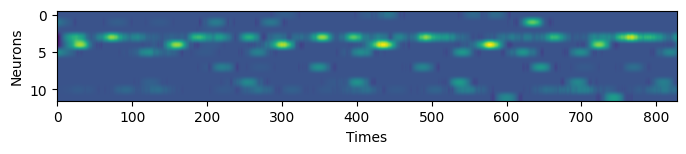

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(data[:1000, :].T, aspect=10)
ax.set_xlabel("Times")
ax.set_ylabel("Neurons");